## `010`: Regression in `scikit-learn`

Goals:
* practice with the `fit` and `predict` interface of sklearn models
* Get a visual sense of how different regression models work.

## Setup

Let's import necessary modules: Pandas and NumPy for data wrangling, Matplotlib for plotting, and some sklearn models.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, log_loss, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

We'll load the data. We're using a dataset of home sale prices from the Ames, Iowa assessor's database, described in [this paper](http://ww2.amstat.org/publications/jse/v19n3/decock.pdf).

In [ ]:
ames = pd.read_csv('https://github.com/kcarnold/AmesHousing/blob/master/data/ames.csv.gz?raw=true', compression="gzip")
ames['price'] = ames["Sale_Price"] / 100_000 # Make `price` be in units of $100k, to be easier to interpret.
ames.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating,Heating_QC,...,First_Flr_SF,Second_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,Three_season_porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude,price
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,Gtl,North_Ames,Norm,Norm,OneFam,One_Story,Above_Average,Average,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112,Typical,Typical,CBlock,Typical,Good,Gd,BLQ,639,Unf,0,441,1080,GasA,Fair,...,1656,0,0,1656,1,0,1,0,3,1,Typical,7,Typ,2,Good,Attchd,Fin,2,528,Typical,Typical,Partial_Pavement,210,62,0,0,0,0,No_Pool,No_Fence,None,0,5,2010,WD,Normal,215000,-93.619754,42.054035,2.150
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,Gtl,North_Ames,Feedr,Norm,OneFam,One_Story,Average,Above_Average,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0,Typical,Typical,CBlock,Typical,Typical,No,Rec,468,LwQ,144,270,882,GasA,Typical,...,896,0,0,896,0,0,1,0,2,1,Typical,5,Typ,0,No_Fireplace,Attchd,Unf,1,730,Typical,Typical,Paved,140,0,0,0,120,0,No_Pool,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.619756,42.053014,1.050
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,Gtl,North_Ames,Norm,Norm,OneFam,One_Story,Above_Average,Above_Average,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108,Typical,Typical,CBlock,Typical,Typical,No,ALQ,923,Unf,0,406,1329,GasA,Typical,...,1329,0,0,1329,0,0,1,1,3,1,Good,6,Typ,0,No_Fireplace,Attchd,Unf,1,312,Typical,Typical,Paved,393,36,0,0,0,0,No_Pool,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659,1.720
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,Gtl,North_Ames,Norm,Norm,OneFam,One_Story,Good,Average,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0,Good,Typical,CBlock,Typical,Typical,No,ALQ,1065,Unf,0,1045,2110,GasA,Excellent,...,2110,0,0,2110,1,0,2,1,3,1,Excellent,8,Typ,2,Typical,Attchd,Fin,2,522,Typical,Typical,Paved,0,0,0,0,0,0,No_Pool,No_Fence,None,0,4,2010,WD,Normal,244000,-93.617320,42.051245,2.440
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,OneFam,Two_Story,Average,Average,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0,Typical,Typical,PConc,Good,Typical,No,GLQ,791,Unf,0,137,928,GasA,Good,...,928,701,0,1629,0,0,2,1,3,1,Typical,6,Typ,1,Typical,Attchd,Fin,2,482,Typical,Typical,Paved,212,34,0,0,0,0,No_Pool,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.638933,42.060899,1.899


We'll define some functions to plot the data and models. Since we have latitude and longitude for each home, we can plot this data in 2D with a color for the sale price.

(Sorry, you'll just have to imagine there's a map underneath.)

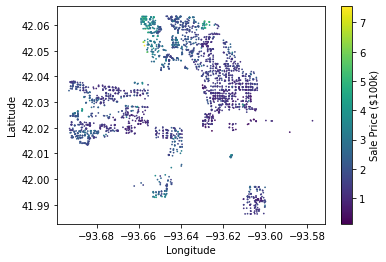

In [ ]:
def plot_data():
    # You don't have to know how this function works.
    plt.scatter(ames['Longitude'], ames['Latitude'], c=ames["price"], s=.5)
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.colorbar(label="Sale Price ($100k)")
plot_data()

We'll try to predict home price based on *location* (which the realtors assure us is the most important factor anyway). So we'll grab the Latitude and Longitude columns of the data. We'll call that input data `X`, by convention.

In [ ]:
X = ames[['Longitude', 'Latitude']].values
X.shape

(2930, 2)

Our target, called `y` by convention, will be the home price (we'll soon introduce a different *y*, but start with this one).

In [ ]:
y = ames['price'].values
y.shape

(2930,)

Notice that `X` has two axes and thus is written in uppercase; `y` has 1 and thus is written in lowercase. (This is `sklearn` convention; other libraries are less consistent about this.)

Now let's split the data into a `train` and `valid` set (which sklearn calls train-*test*, but that's fine). `random_state` is how `sklearn` specifies the random seed (it's actually slightly more flexible than a seed).

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=42)

We'll verify that the shapes make sense.

In [ ]:
X_train.shape, y_train.shape

((2344, 2), (2344,))

In [ ]:
X_valid.shape, y_valid.shape

((586, 2), (586,))

Here's a function to plot our regression model in "data space" (i.e., what it would predict everywhere on the map.

This function is pretty customized to our specific use case, though you can get inspiration from it for use in other situations.

In [ ]:
def plot_model(clf):
    # Compute extents
    lat_min = ames.Latitude.min()
    lat_max = ames.Latitude.max()
    lon_min = ames.Longitude.min()
    lon_max = ames.Longitude.max()
    price_min = ames.price.min()
    price_max = ames.price.max()

    # Ask the classifier for predictions on a grid
    xx, yy = np.meshgrid(np.linspace(lon_min, lon_max, 250), np.linspace(lat_min, lat_max, 250))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Show the predictions. Superimpose the original data.
    plt.figure(figsize=(16, 8))
    plt.contourf(xx, yy, Z, alpha=.5, cmap=plt.cm.viridis, vmin=price_min, vmax=price_max)
    plt.scatter(ames['Longitude'], ames['Latitude'], c=ames["price"], s=1, cmap='viridis', vmin=price_min, vmax=price_max)
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.colorbar(label="Sale Price ($100k)");


## Task

### Part A: Linear regression

1. Fit a linear regression model (call it `linreg`) to the training set (`X_train`, `y_train`).
2. Plot the model's predictions in data space. Describe the result qualitatively.
3. Compute the model's predictions on the validation set (call them `y_pred`). What does the model predict for the first house in the validation set? How does that compare with the actual price for that home?
4. Compute and show the mean squared error and the mean absolute error for the validation set predictions. You may use the `mean_absolute_error` and `mean_squared_error` functions that were imported from `sklearn.metrics` above.

**Fit a linear regression model (call it `linreg`) to the training set (`X_train`, `y_train`).**

In [ ]:
linreg = LinearRegression().fit(X_train, y_train)

**Plot the model's predictions in data space. Describe the result qualitatively**. The code for step is filled in for you because there's not a generic way to do this; our approach here is customized to our particular model and task so you don't have to understand the details of how it works.

The important aspect of this step is the qualitative description of how this model compares with the decision tree models used later. So come back and write this description once you've also seen the decision tree model outputs.

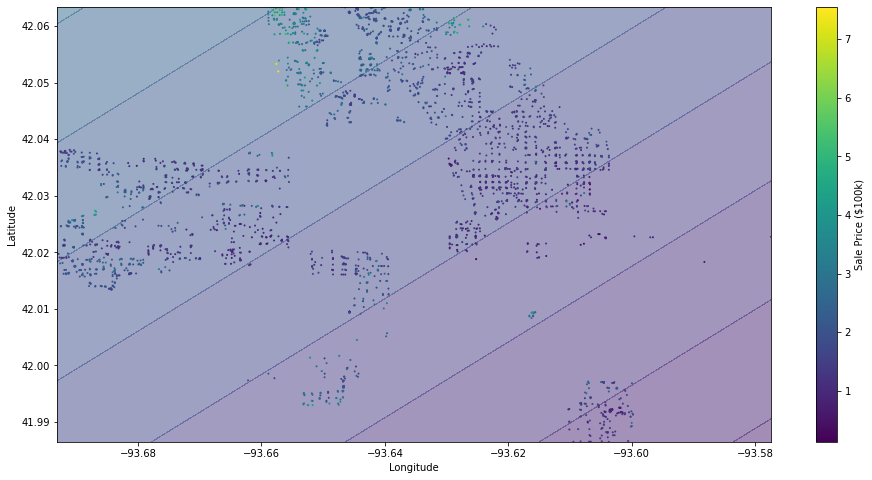

In [ ]:
plot_model(linreg)

All of the linear regression model's predictions are around \$300k or below. It seems to make gradient-like predictions, with the cheapest houses sold at the bottom left and the most expensive houses sold at the top right. The decision tree model, however, is much more nuanced. Its predictions are all across the spectrum of possible sale prices, and it has rectangular sections to specify where homes of particular prices are. These rectangular sections/predictions seem to fit the data much more accurately than the linear regression model's predictions.

**Compute the model's predictions on the validation set (call them `y_pred`). What does the model predict for the first house in the validation set? How does that compare with the actual price for that home?**

In [ ]:
y_pred = linreg.predict(X_valid)

In [ ]:
y_valid[0], y_pred[0]

(1.61, 1.5543284848404255)

The model predicts that the first house will cost about \$155,432. The actual price for the home is \$161,000, meaning the prediction was off by about \$5,567.

**Compute and show the mean squared error and the mean absolute error for the validation set.**

* You may use the `mean_absolute_error` and `mean_squared_error` functions (imported from `sklearn.metrics` above).
* Use the predictions you already made above.
* Use Shift-TAB or `?` to get the documentation for these functions to ensure you're passing the arguments in the correct order.

In [ ]:
mean_absolute_error(y_true=y_valid, y_pred=y_pred), mean_squared_error(y_true=y_valid, y_pred=y_pred)

(0.5821366485782289, 0.6786574994305038)

### Part B: Decision tree regression

1. Fit a decision tree model (call it `dtree_reg`) to the training set.
2. Repeat steps 2 and 4 from Part A using this model.
3. Compare `dtree_reg` with `linreg`. Which is better? How can you tell?

**Fit a decision tree model (call it `dtree_reg`) to the training set (`X_train`, `y_train`).**

In [ ]:
dtree_reg = DecisionTreeRegressor().fit(X_train, y_train)

**Repeat steps 2 and 4**...

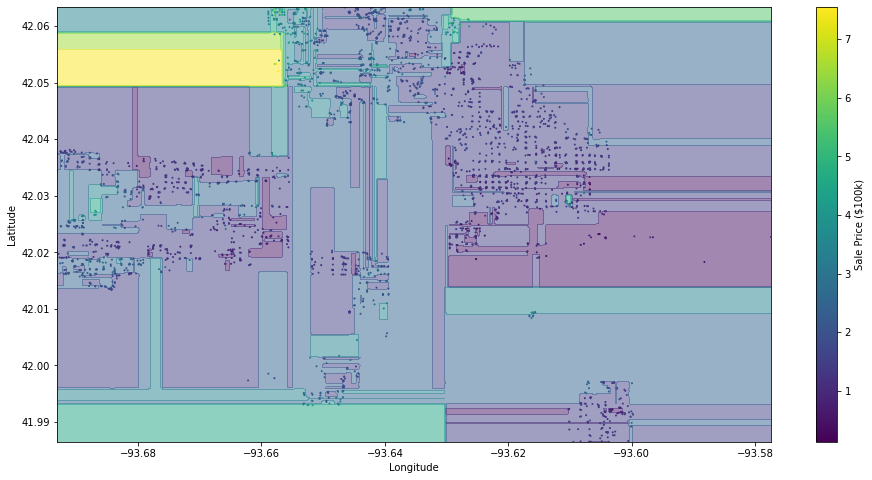

In [ ]:
plot_model(dtree_reg)

It seems that using the decision tree is better than linear regression, as our mean absolute error and mean squared error are both lower when using the decision tree.

### Part C: Random Forest regression

1. Fit a random forest regression model to this data.
2. Compare its performance quantitatively with the linear regression and decision tree models fit above.
3. Compare its data-space plot with the decision tree model.

**Fit a random forest regression model to this data.** Use the default hyperparameters.

In [ ]:
rf_reg = RandomForestRegressor().fit(X_train, y_train)

**Compare its performance quantitatively with the linear regression and decision tree models fit above.**

You might notice differences in the shapes of the boundaries it draws and, if you look more closely, a difference in how the boundaries relate to the data.

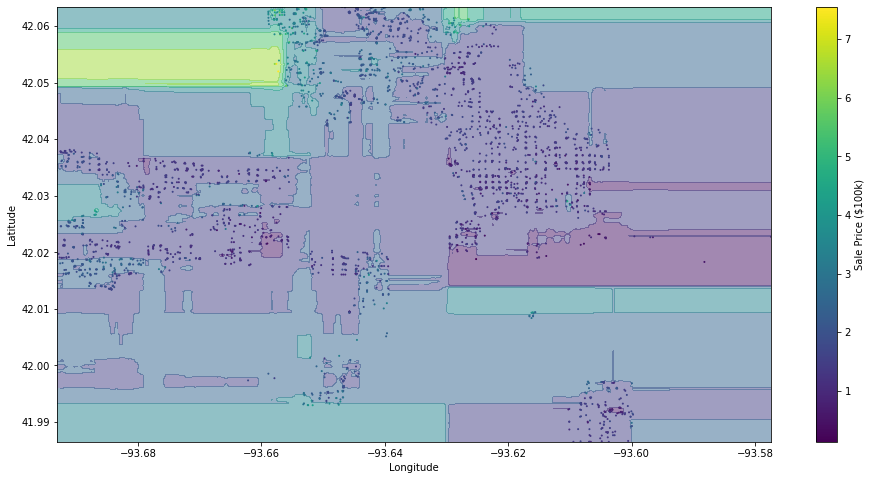

In [ ]:
plot_model(rf_reg)

The shapes from the random forest plot are much less sharp than those in the decision tree and the linear regression plots. There are more "detailed" parts (meaning small holes and protrusions) in some of the shapes from this plot, whereas the decision tree plot was more "blocky."

In [ ]:
y_pred_rf = rf_reg.predict(X_valid)
mean_absolute_error(y_true=y_valid, y_pred=y_pred_rf), mean_squared_error(y_true=y_valid, y_pred=y_pred_rf)

(0.2884863124776531, 0.20196180833189398)

## Analysis

Out of each of the models I used, the random forest model made the most accurate predictions with the validation set. Both the mean absolute error and the mean squared error were the lowest for the random forest model. Additionally, the shape of the predictions on the random forest's plot were much more detailed than the other two, indicating that the random forest had more precision when predicting areas of certain sale prices.

## Extension

*optional*

1. Compute the loss on the *training* set for each of these models. Can that help you tell whether the model overfit or not?
2. Try using more features in the dataset. How well can you predict the price? Be careful about *categorical* features.